# KALMAN FILTERS
## AA 549/AE 514 - UW

#### Dan Calderone - djcal@uw.edu

### DYNAMICS CASE 1: LTI SYSTEM (TEST CASE)

In [1]:
import numpy as np
import numpy.linalg as mat
import scipy.linalg as smat
from numpy.random import multivariate_normal as vecnormal # draw from a vector normal distribution
from numpy.random import normal as normal  # draw from a normal distribution
# mvnrnd -- Matlab function


n = 3; # state vector length
q = 3; # process noise vector length
m = 1; # number of control inputs
o = 2; # number of measurements 
tf = 2; T = 600; 
dt = tf/T; ts = np.linspace(0,tf,T)
# Dynamics matrices - definitions

x  = np.zeros([T,n]); # true state vector 
xh = np.zeros([T,n]); # xhat estimate state
xhm= np.zeros([T,n]); # x hat minus
xhp= np.zeros([T,n]); # xhat plus
y  = np.zeros([T,o]); # measurements... (y tilde)
yh = np.zeros([T,o]); # y hat...
ey = np.zeros([T,o]); # error in y... e=y-yhat
P  = np.zeros([T,n,n]); #P minus...
Pm = np.zeros([T,n,n]); #P minus...
Pp = np.zeros([T,n,n]);  #P plus... 

eigP = np.zeros([T,n]); # eigenvalues of P
eigPm= np.zeros([T,n]); # eigenvalues of P minus
eigPp= np.zeros([T,n]); # eigenvalues of P plus

K  = np.zeros([T,n,o]);   # gain matrices... 
w  = np.zeros([T,q]); # process noise
v  = np.zeros([T,o]); # measurement noise...

Q = 1.*np.eye(q); # process noise... "how noisy the dynamics are"
R = 0.5*np.eye(o); # measurement noise... "how noisy the measurement is"

u  = np.array([np.sin(ts)]).T;


# continuous time dynamics matrices...
F = np.array([[-1.,3,0],
              [0,-2.,-2],
              [0,0,-3.]]);
B = np.array([[1],[1],[1]]);
G = np.eye(3);

# discrete time dynamics matrices... ROUGH ESTIMATE
# Matlab function: ~~ c2d(A,B,C,D,dt)
#x^+ = x+dt\dot(x) = (I+dt*F)x
# Forward euler 
Phi = np.eye(n)+dt*F; ## BETTER: Phi = expm(dt*F) = I + dt*F + 1/2 dt^2 F^2 + ...
Gam = dt*B; ## BETTER Gam = \int_0^{dt} expm(F(dt-tau))dtau B
Ups = dt*G; ## BETTER Ups = \int_0^{dt} expm(F(dt-tau))dtau G
# \dot(x) = Fx + Bu + Gw
# x+ = x + dt*f(x,u,w) = x+dt*(Fx+Bu+Gw) = (I+dt*F)x+dt*Bu+dt*Gw

# Measurement matrix
H   = np.array([[1,1,1],[1,-1,-1]]);

# more important in nonlinear case
def f(x,u,w=np.zeros(n)): return F@x+B@u+G@w
def h(x,v=np.zeros(o)): return H@x+v
def dfdx(x,u): return F
def dhdx(x): return H
def phi(x,u,w=np.zeros(n)): return Phi@x+Gam@u+Ups@w
## x^+ = phi(x,u,w)

## initializing states and covariance matrix...
# true state
x[0]  = np.array([1,1,1]);

# state estimates
xh[0] = -np.array([1,1,1]);  # continuous time...
xhm[0]= -np.array([1,1,1]);  # discrete time case...

# Error covariances...
P[0]  = np.eye(3); # continous time - NOT SUPER IMPORTANT
Pm[0] = 0.5*np.eye(n); #discrete time - NOT SUPER IMPORTANT


## Discrete Time Kalman Filter
    
\begin{align*}
\textbf{Model:} & \qquad 
x_{k+1} = \Phi_k x_k + \Gamma_k u_k + \Upsilon_k w_k, \qquad w_k \sim \mathcal{N}(0,R_k) \\
& \qquad \tilde{y}_k  = H_kx_k + v_k, \qquad v_k \sim \mathcal{N}(0,R_k) \\
\textbf{Initialize:} & \qquad \hat{x}  (t_0) = \hat{x}_0, \qquad P_0 = E\big[(\hat{x}_0-x_0)(\hat{x}_0-x_0)^T\big] \\
\textbf{Gain:} &  \qquad
K_k = P_k^-H_k^T\big[H_k P_k^- H_k^T + R_k]^{-1} \\
\textbf{Update:} & \qquad 
\hat x_k^+ = \hat x_k^- + K_k[\tilde y_k-H_k \hat x_k^-] \\
& \qquad P_k^+ = \big[I-K_k H_k\big] P_k^- \\
\textbf{Propagation:} & \qquad 
\hat{x}_{k+1}^- = \Phi_k \hat{x}_k^+ + \Gamma_ku_k \\
& \qquad 
P_{k+1}^-  = \Phi_k P_k^+ \Phi_k^T + \Upsilon_k Q_k \Upsilon_k^T
\end{align*}


#### Alternative Forms:
\begin{align*}
    P_k^+ &  = \big[I-K_k H_k\big]P_k^-\big[I-K_kH_k\big]^T + K_kR_kK_k^T \\
    P_k^+ & = P_k^- - P_k^-H_k^T\big[H_kP_k^-H_k^T + R_k \big]^{-1} H_k P_k^- \\
P_k^+ & = \big[(P_k^-)^{-1} + H_k^TR_k^{-1}H_k \big]^{-1}
\end{align*}
\begin{align*}
    K_k = P_k^+H_k^TR_k^{-1}, \qquad
    \big[I-K_kH_k\big] = P_k^+(P_k^{-1})^{-1}, \qquad 
    \hat{x}_k^+ = P_k^+\big[(P_k^-)^{-1}\hat x_k^- + H_k^TR_k^{-1}\tilde y_k\big]
\end{align*}

#### Combined Form
\begin{align*}
\hat x_{k+1} & = \Phi_k \hat x_k + \Gamma_k u_k +
\Phi_k K_k \big[\tilde y_k - H_k\hat x_k\big] \\
K_k & = P_k H_k^T\big[H_k P_k H_k^T + R_k \big]^{-1} \\
\textbf{Discrete Riccati Eqn.} \qquad
P_{k+1} & = 
\Phi_k P_k \Phi_k^T - \Phi_k P_k H_k^T \big[H_kP_k H_k^T+R_k\big]^{-1} H_k P_k \Phi_k^T + \Upsilon_k Q_k \Upsilon_k^T \\
\textbf{Other forms}
\qquad
P_{k+1} & = 
\Phi_k P_k \Phi_k^T - \Phi_k K_k \big[H_kP_k H_k^T+R_k\big]
K_k^T
\Phi_k^T
 + \Upsilon_k Q_k \Upsilon_k^T \\
& = 
\Phi_k P_k \Phi_k^T - \Phi_k K_k H_k P_k
\Phi_k^T
 + \Upsilon_k Q_k \Upsilon_k^T
\end{align*}



### Infinite Horizon
\begin{align*}
K_\infty &  = P_\infty H^T\big[H P_\infty H^T + R\big]^{-1} \\
\textbf{DT Alg. Riccati Eqn. (DARE)} \qquad
P_\infty & = 
\Phi P_\infty \Phi - \Phi P_\infty H^T \big[HP_\infty H^T+R\big]^{-1} H P_\infty \Phi^T + \Upsilon Q \Upsilon^T \\
\textbf{DARE other forms}
\qquad
P_\infty & = 
\Phi P_\infty \Phi - \Phi K_\infty \big[HP_\infty H^T+R\big]
K_\infty^T
\Phi^T
 + \Upsilon Q \Upsilon^T \\
& = 
\Phi P_\infty \Phi - \Phi K_\infty H P_\infty
\Phi^T
 + \Upsilon Q \Upsilon^T
\end{align*}

## simulate real trajectory...

In [2]:
for t in range(T): # for t=1:T;
    # w(t) = mvnrnd(mu,Q) ## Matlab
    w[t] = vecnormal(np.zeros(q),Q); # process noise...
    if t < T-1: # run except at the final time...
        x[t+1]= Phi@x[t]+Gam@u[t] + Ups@w[t];


## filter...

In [3]:
from scipy.linalg import solve_discrete_are as DARE #CARE


# looping through time...
# range(T) = [0,1,2,...,T-1]
inf_horizon = False
if inf_horizon:
    infP = DARE(Phi.T, H.T, Ups@Q@Ups.T, R)  # matlab version: idare()
    infK = infP@H.T@mat.inv(H@infP@H.T+R);
    
for t in range(T): # Matlab - for t=1:T
    # MEASUREMENT UPDATE...
    eigPm[t] = np.sort(mat.eig(Pm[t])[0]); # computes the eigenvalues of P minus
    
    v[t]  = vecnormal(np.zeros(o),R);# v(t,:,:)  = mvnrnd(zeros(2),R)
    # simulation of sensors...
    y[t]  = H@x[t] + v[t];   # y(t,:,:)  = H*x(t,:,:)+v(t,:,:)
    # predicting y hat...
    yh[t] = np.dot(H,xhm[t]);        # yh(t,:,:) = H*xhm(t,:,:)
    
    # gain computation
    if not(inf_horizon):
        K[t]  = Pm[t]@H.T@mat.inv(H@Pm[t]@H.T + R);  # @ - matrix multiplication
        Pp[t] = (np.eye(n)-K[t]@H)@Pm[t]; # updating covariance...
    else:
        K[t] = infK;
        Pp[t]= infP;
    # measurement update...
    xhp[t] = xhm[t] + K[t]@(y[t]-yh[t]);  # updating estimate...    
    eigPp[t] = np.sort(mat.eig(Pp[t])[0]);
    # dynamics...
    if t < T-1: # run except at the final time...
        xhm[t+1]= Phi@xhp[t]+Gam@u[t]; # estimate dynamics.
        if not(inf_horizon):
            Pm[t+1] = Phi@Pp[t]@Phi.T + Ups@Q@Ups.T;
        else:
            Pm[t+1]= infP;
            
        


## discrete - visualize...

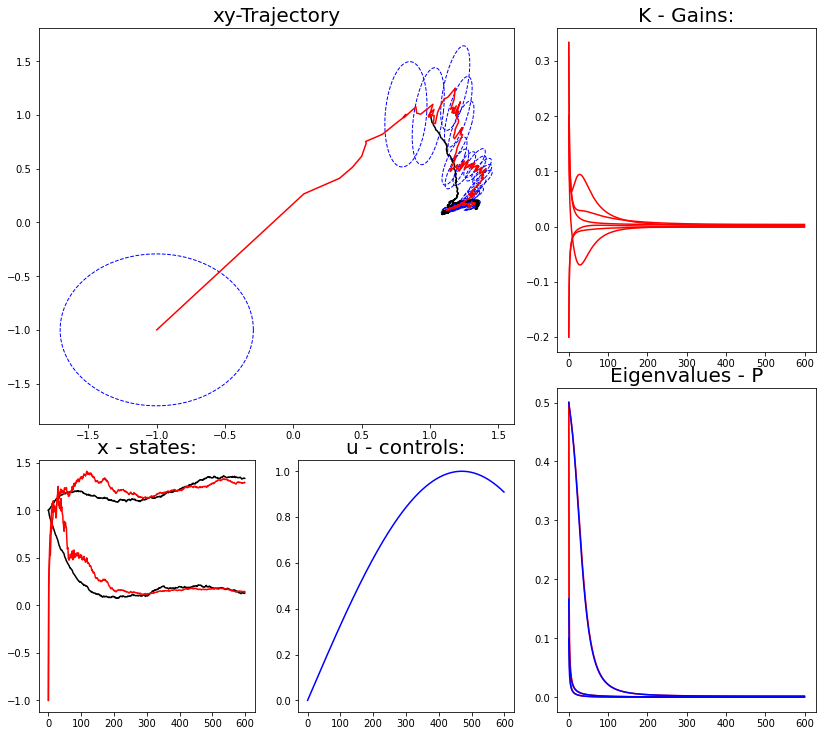

In [4]:
import matplotlib.pyplot as plt

import matplotlib.patches as patches, matplotlib as mpl
from matplotlib.patches import Polygon

# drawing an ellipse shape
def ellipse(mu,P): #draws an ellipse with shape P (covariance matrix) around the point mu
    thetas = np.linspace(0,2*np.pi,100);
    Phalf = smat.sqrtm(P);
    return mu+np.dot(Phalf,np.array([np.cos(thetas),np.sin(thetas)])).T;


fig,ax = plt.subplots(1,5,figsize=(12,10));

ax[0].set_position([0.05,0.45,0.55,0.55]); #gs[0:2].get_position(fig))
ax[1].set_position([0.05,0.05,0.25,0.35]); #gs[0:2].get_position(fig))
ax[2].set_position([0.35,0.05,0.25,0.35]); #gs[0:2].get_position(fig))
ax[3].set_position([0.65,0.55,0.3,0.45]); #gs[0:2].get_position(fig))
ax[4].set_position([0.65,0.05,0.3,0.45]); #gs[0:2].get_position(fig))


ax[0].set_title('xy-Trajectory',fontsize=20) # title
#ax[0].set_xlim([-1.5,1.5]); ax[0].set_ylim([-1,1]) # axes limits

# Plotting 
ax[0].plot(x[:,0],x[:,1],'k-') # true state trajectory
ax[0].plot(xhm[:,0],xhm[:,1],'r-') #estimate state trajectory


for t in range(T)[::10]:
    pts = list(ellipse(xhm[t][:2],Pm[t][:2,:2]))
    ax[0].add_patch(Polygon(pts,closed=True,fill=False,linestyle='--',edgecolor='blue'));  
    # Options: facecolor,linestyle,edgecolor,linewidth,alpha,fill,zorder
    
    
ax[1].plot(x[:,:2],'k-');  ax[1].set_title('x - states:',fontsize=20)
ax[1].plot(xhm[:,:2],'r-'); 

ax[2].plot(u,'b-'); ax[2].set_title('u - controls:',fontsize=20);
    
ax[3].set_title('K - Gains:',fontsize=20);
for i in range(K.shape[2]):
    ax[3].plot(K[:,:,i],'r-');

ax[4].set_title('Eigenvalues - P',fontsize=20);
ax[4].plot(eigPm,'r-')
ax[4].plot(eigPp,'b-')

### DYNAMICS CASE 2: $\alpha-\beta$ filter -- Object tracking model - assuming constant velocity

True Dynamics (velocity model): 

\begin{align*}
\begin{bmatrix}
\dot{x}_1 \\ \dot{x}_2
\end{bmatrix} = 
\begin{bmatrix}
u_1 \\ u_2 
\end{bmatrix} 
\end{align*}

Modeled Dynamics - 2nd order dynamics (velocity unknown): 

\begin{align*}
\begin{bmatrix}
\dot{x}_1 \\ \dot{x}_2 \\
\ddot{x}_1 \\ \ddot{x}_2
\end{bmatrix} & = Fx+Gw = 
\begin{bmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0
\end{bmatrix}
\begin{bmatrix}
x_1 \\ x_2 \\
\dot{x}_1 \\ \dot{x}_2
\end{bmatrix}
+
\begin{bmatrix}
0 & 0 \\
0 & 0 \\
1 & 0 \\
0 & 1 
\end{bmatrix}
\begin{bmatrix}
w_1 \\ w_2
\end{bmatrix} \\
\tilde{y} & = Hx +v =
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
\end{bmatrix}
\begin{bmatrix}
x_1 \\ x_2 \\ \dot{x}_1 \\ \dot{x}_2
\end{bmatrix}
+
\begin{bmatrix}
v_1 \\ v_2
\end{bmatrix}
\end{align*}


In [16]:
import numpy as np
import numpy.linalg as mat
from numpy.random import multivariate_normal as vecnormal # draw from a vector normal distribution
from numpy.random import normal as normal  # draw from a normal distribution


n = 4; # state vector length
q = 2; # number of noise measurements
m = 2; # number of control inputs
o = 2; # number of measurements 
tf = 10; T = 1000; dt = tf/T;
ts = np.linspace(0,tf,T);
u  = np.zeros((T,m));

x  = np.zeros([T,n]); # true state vector 
xh = np.zeros([T,n]);
xhm= np.zeros([T,n]);
xhp= np.zeros([T,n]); # xhat minus and xhat plus
y  = np.zeros([T,o]); # measurements... (y tilde)
yh = np.zeros([T,o]); # y hat...
ey = np.zeros([T,o]); # error in y... e=y-yhat
P  = np.zeros([T,n,n]); #P minus...
Pm = np.zeros([T,n,n]); #P minus...
Pp = np.zeros([T,n,n]);  #P plus... 
K  = np.zeros([T,n,o]);   # gain matrices... 
w  = np.zeros([T,q]);
v  = np.zeros([T,o]); # noise terms...
eigP = np.zeros([T,n]);
eigPm= np.zeros([T,n]);
eigPp= np.zeros([T,n]);

F = np.array([[0,0,1,0],
              [0,0,0,1],
              [0,0,0,0],
              [0,0,0,0]]);
B = np.array([[0,0,0,0],[0,0,0,0]]).T;
G = np.array([[0,0,1,0],[0,0,0,1]]).T;

Phi = np.eye(n)+dt*F;
Gam = dt*B;
Ups = dt*G;
H   = np.array([[1,0,0,0],[0,1,0,0]]); 



def f(x,u,w=np.zeros(n)): return F@x+B@u+G@w
def h(x,v=np.zeros(o)): return H@x+v
def dfdx(x,u): return F
def dhdx(x): return H
def phi(x,u,w=np.zeros(n)): return Phi@x+Gam@u+Ups@w


## initializing states and covariance matrix...
x[0] = np.array([0,0,0,0]);
xh[0] = -np.array([1,1,1,1]); 
xhm[0] = -np.array([1,1,1,1]); 


# Noise covariances...
P[0] = 0.1*np.eye(n); #guessed initial error - NOT IMPORTANT
Pm[0] = 0.1*np.eye(n); #guessed initial error - NOT IMPORTANT

# True state trajectory - just defining the position states
x[:,:2] = np.array([0.1*ts*np.cos(ts),0.1*ts*np.sin(ts)]).T;

#     if t < T-1: # run except at the final time...
#         w[t] = vecnormal(np.zeros(n),Q); # process noise...
#         x[t+1] = x[t]phi(x[t],u[t],w[t])

Q = 0.2*np.eye(q); # process noise... "how noisy the dynamics are"
R = 0.01*np.eye(o); # measurement noise... "how noisy the measurement is"

for t in range(T): # Matlab - for t=1:T
    w[t] = vecnormal(np.zeros(q),Q); # process noise...
    x[t] = x[t] + Ups@w[t]




## Continuous Time Kalman Filter
    
\begin{align*}
\textbf{Model:} &  \qquad 
\dot{x}(t)  = F(t) x(t) + B(t) u(t) + G(t)w(t), \qquad w(t) \sim \mathcal{N}\big(0,Q(t)\big)  \\
& \qquad \tilde{y}(t)  = H(t)x(t) + v(t), \qquad v(t) \sim \mathcal{N}\big(0,R(t)\big)  \\
& \qquad E[w(t)w(\tau)^T]  = Q(t) \delta(t-\tau) \\
& \qquad E[v(t)v(\tau)^T]  = R(t)\delta(t-\tau) \\
& \qquad E[v(t)w(\tau)^T]  = 0
\\
\textbf{Initialize:} & \qquad \hat{x}  (t_0) = \hat{x}_0, \qquad P_0 = E\big[(\hat{x}(0)-x(0))(\hat{x}(0)-x(0))^T\big] \\
\textbf{Gain:} &  \qquad
K(t) = P(t)H^T(t)R^{-1}(t)\\
\textbf{Covariance:} & \qquad 
\dot P(t) = F(t)P(t) + P(t) F^T(t) - P(t) H^T(t)R^{-1}(t)H(t)P(t) + G(t)Q(t)G^T(t)\\
\textbf{Estimate:} & \qquad 
\dot{\hat{x}} = F(t)\hat{x}(t) + B(t) u(t) + K(t) \big[\tilde{y}(t)-H(t)\hat{x}(t)\big]
\end{align*}

#### Alternative Forms:
\begin{align*}
\dot P(t) = F(t)P(t) + P(t)F(t)^T + K(t)R(t)K(t)^T + G(t)Q(t)G(t)^T
\end{align*}


### Infinite Horizon
\begin{align*}
K_\infty & = P_\infty H^T R^{-1} \\
\textbf{CT Alg. Riccati Eqn. (CARE)} \qquad 
0 & = F P_\infty + P_\infty F^T - P_\infty H^TR^{-1}HP_\infty + GQG^T \\
0 & = F P_\infty + P_\infty F^T + K_\infty R K_\infty^T + GQG^T
\end{align*}



### simulate real trajectory?...(NOT NEEDED - TRAJECTORY COMPUTED ABOVE)

In [17]:
# for t in range(T): # Matlab - for t=1:T
#     if t < T-1: # run except at the final time...
#         w[t]   = vecnormal(np.zeros(q),Q);
#         ### FORWARD EULER UPDATE - NOT VERY PRECISE - ODE45 would be more precise...    
#         #x[t+1] = x[t]  + dt*(F@x[t] +B@u[t]+G@w[t]);
#         x[t+1] = x[t] + dt*f(x[t],u[t],w[t]);

### continuous - filter

In [18]:
import numpy as np
import numpy.linalg as mat
from numpy.random import multivariate_normal as vecnormal
from numpy.random import normal as normal

from scipy.linalg import solve_continuous_are as CARE
    
inf_horizon = True
if inf_horizon:
    infP = CARE(F.T, H.T, G@Q@G.T, R)  # matlab version: idare()
    infK = infP@H.T@mat.inv(R);

for t in range(T):    
    
    eigP[t] = np.sort(mat.eig(P[t])[0]); 
    v[t]  = vecnormal(np.zeros(2),R);
    y[t]  = H@x[t] + v[t];
    yh[t] = H@xh[t];
    if not(inf_horizon):
        K[t]  = P[t]@H.T@mat.inv(R);
    else:
        K[t] = infK;
    if t < T-1:
        # propagating the estimate... forward euler
        xh[t+1]= xh[t] + dt*(F@xh[t]+B@u[t]+K[t]@(y[t]-yh[t]));
        if not(inf_horizon):
            # forward euler for the continuous time riccati equation...
            # ODE45...
            P[t+1] = P[t]+dt*(F@P[t]+P[t]@F.T - P[t]@H.T@mat.inv(R)@H@P[t] + G@Q@G.T);            
        else:
            P[t+1] = infP;


## continuous - visualize

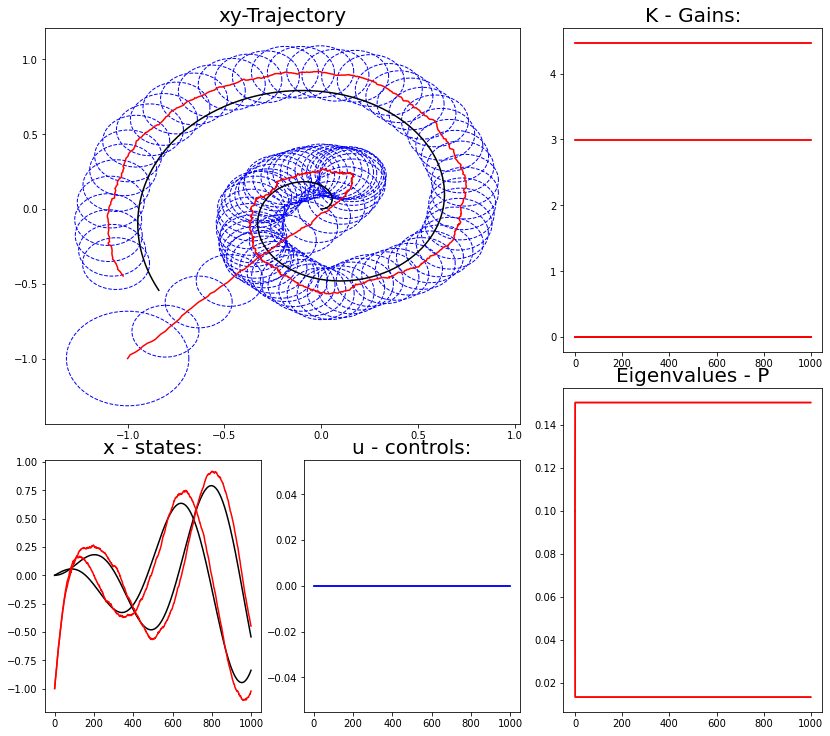

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches, matplotlib as mpl
from matplotlib.patches import Polygon

def ellipse(mu,P):
    thetas = np.linspace(0,2*np.pi,100);
    Phalf = smat.sqrtm(P);
    return mu+np.dot(Phalf,np.array([np.cos(thetas),np.sin(thetas)])).T;


fig,ax = plt.subplots(1,5,figsize=(12,10));

ax[0].set_position([0.05,0.45,0.55,0.55]); #gs[0:2].get_position(fig))
ax[1].set_position([0.05,0.05,0.25,0.35]); #gs[0:2].get_position(fig))
ax[2].set_position([0.35,0.05,0.25,0.35]); #gs[0:2].get_position(fig))
ax[3].set_position([0.65,0.55,0.3,0.45]); #gs[0:2].get_position(fig))
ax[4].set_position([0.65,0.05,0.3,0.45]); #gs[0:2].get_position(fig))


ax[0].set_title('xy-Trajectory',fontsize=20)
ax[0].plot(x[:,0],x[:,1],'k-')
ax[0].plot(xh[:,0],xh[:,1],'r-')

#ax[0].set_xlim([-2,2])
#ax[0].set_ylim([-2,2])
for t in range(T)[::10]:
    ax[0].add_patch(Polygon(list(ellipse(xh[t][:2],P[t][:2,:2])),
                      closed=True,fill=False,linestyle='--',edgecolor='blue'))    
    # Options: facecolor,linestyle,edgecolor,linewidth,alpha,fill,zorder
    
    
ax[1].plot(x[:,:2],'k-');  ax[1].set_title('x - states:',fontsize=20)
ax[1].plot(xh[:,:2],'r-'); 

ax[2].plot(u,'b-'); ax[2].set_title('u - controls:',fontsize=20);
    
ax[3].set_title('K - Gains:',fontsize=20);
for i in range(K.shape[2]):
    ax[3].plot(K[:,:,i],'r-');

ax[4].set_title('Eigenvalues - P',fontsize=20);
ax[4].plot(eigP,'r-')
#ax[4].plot(eigPp,'b-')

## Continuous-Discrete Time Kalman Filter
    
\begin{align*}
\textbf{Model:} &  \qquad 
\dot{x}(t)  = F(t) x(t) + B(t) u(t) + G(t)w(t), \qquad w(t) \sim \mathcal{N}\big(0,Q(t)\big)  \\
& \qquad \tilde{y}_k  = H_kx_k + v_k, \qquad v_k \sim \mathcal{N}\big(0,R_k\big)  \\
\textbf{Initialize:} & \qquad \hat{x}  (t_0) = \hat{x}_0, \qquad P_0 = E\big[(\hat{x}(0)-x(0))(\hat{x}(0)-x(0))^T\big] \\
\textbf{Gain:} &  \qquad
K_k = P_k^-H_k^T\big[H_kP_k^-H_k^T + R_k\big]^{-1} \\
\textbf{Update:} & \qquad \hat{x}_k^+ = \hat x_k^- + K_k\big[\tilde{y}_k-H_k\hat{x}_k^-\big] \\
& \qquad P_k^+ = \big[I-K_k H_k\big]P_k^- \\
\textbf{Propagation:} & \qquad
\dot{\hat{x}}(t) = F(t) \hat{x}(t) + B(t)u(t) \\
& \qquad 
\dot P(t) = F(t)P(t) + P(t) F^T(t) + G(t)Q(t)G(t)^T 
\end{align*}



### simulate real dynamics...(NOT NEEDED - TRAJECTORY COMPUTED ABOVE)

In [20]:
# for t in range(T):    
#     w[t] = vecnormal(np.zeros(q),Q);    
#     if t < T-1:
#         x[t+1] = x[t]  + dt*(F@x[t] +B@u[t]+G@w[t]);        

## filter...

In [21]:
import numpy as np
import numpy.linalg as mat
from numpy.random import multivariate_normal as vecnormal
from numpy.random import normal as normal

sample_steps = np.array(range(T)[::10]) # selecting sample times

for t in range(T):
    
    eigP[t] = np.sort(mat.eig(P[t])[0]);     
    ### Continuous time loop:
    v[t]  = vecnormal(np.zeros(o),R);
    y[t]  = np.dot(H,x[t]) + v[t];
    yh[t] = np.dot(H,xh[t]);
    
    ## Discrete time update 
    if t in sample_steps: # only using measurement to update the state at every 20th time step 
        K[t] = P[t]@H.T@mat.inv(H@P[t]@H.T + R);
        xh[t]= xh[t] + np.dot(K[t],y[t]-yh[t]);
        P[t] = (np.eye(n)-K[t]@H)@P[t]; 
    
    # DYNAMICS UPDATE HAPPENS EVERY TIME
    if t < T-1:
        xh[t+1]= xh[t] + dt*(F@xh[t]+B@u[t]);
        P[t+1] = P[t]+dt*(F@P[t]+P[t]@F.T + G@Q@G.T);
        K[t+1] = K[t];        
        
        

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


#### Discrete Time - Visualize

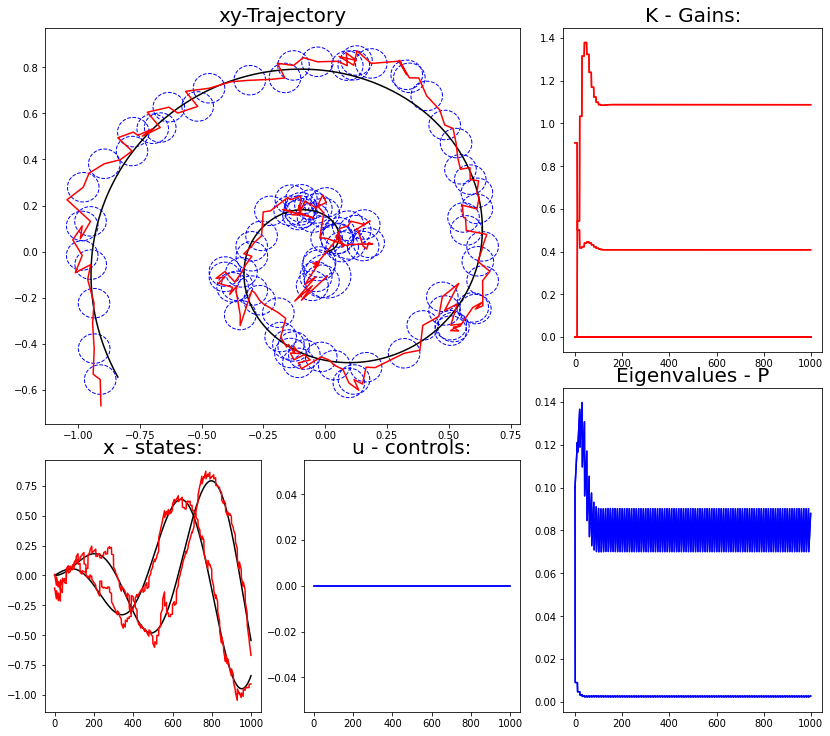

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches, matplotlib as mpl
from matplotlib.patches import Polygon

def ellipse(mu,P):
    thetas = np.linspace(0,2*np.pi,100);
    Phalf = smat.sqrtm(P);
    return mu+np.dot(Phalf,np.array([np.cos(thetas),np.sin(thetas)])).T;


fig,ax = plt.subplots(1,5,figsize=(12,10));

ax[0].set_position([0.05,0.45,0.55,0.55]); #gs[0:2].get_position(fig))
ax[1].set_position([0.05,0.05,0.25,0.35]); #gs[0:2].get_position(fig))
ax[2].set_position([0.35,0.05,0.25,0.35]); #gs[0:2].get_position(fig))
ax[3].set_position([0.65,0.55,0.3,0.45]); #gs[0:2].get_position(fig))
ax[4].set_position([0.65,0.05,0.3,0.45]); #gs[0:2].get_position(fig))


ax[0].set_title('xy-Trajectory',fontsize=20)
ax[0].plot(x[:,0],x[:,1],'k-')
ax[0].plot(xh[:,0],xh[:,1],'r-')

for t in range(T)[::10]:
    ax[0].add_patch(Polygon(list(ellipse(xh[t][:2],P[t][:2,:2])),
                      closed=True,fill=False,linestyle='--',edgecolor='blue'))    
    # Options: facecolor,linestyle,edgecolor,linewidth,alpha,fill,zorder
    
    
ax[1].plot(x[:,:2],'k-');  ax[1].set_title('x - states:',fontsize=20)
ax[1].plot(xh[:,:2],'r-'); 


ax[2].plot(u,'b-'); ax[2].set_title('u - controls:',fontsize=20);
    
ax[3].set_title('K - Gains:',fontsize=20);
for i in range(K.shape[2]):
    ax[3].plot(K[:,:,i],'r-');

ax[4].set_title('Eigenvalues - P',fontsize=20);
ax[4].plot(eigP,'b-')
#ax[4].plot(eigPp,'b-')

### DYNAMICS CASE 3: Nonlinear Unicycle dynamics model  - simplest model of a car

##### CT Dynamics: 


\begin{align*}
\begin{bmatrix}
\dot{x}_1 \\ \dot{x}_2 \\
\dot{v} \\
\dot{\theta} 
\end{bmatrix} & =
f(x_1,x_2,v,\theta,u_1,u_2) = 
\begin{bmatrix}
v\cos(\theta) \\ v\sin(\theta) \\ 0 \\ 0
\end{bmatrix}
+
\begin{bmatrix}
0 & 0 \\ 0 & 0 \\ 1 & 0 \\ 0 & 1 
\end{bmatrix}
\begin{bmatrix}
u_1 \\ u_2
\end{bmatrix} +
\begin{bmatrix}
1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 3 \\
0 & 0 & 0 
\end{bmatrix}
\begin{bmatrix}
w_1 \\ w_2 \\ w_3
\end{bmatrix} \\
\tilde{y} & =
h(x_1,x_2,v,\theta) = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
x_1 \\ x_2 \\ v \\ \theta 
\end{bmatrix}
+
\begin{bmatrix}v_1 \\ v_2 \\ v_3 \\ v_4\end{bmatrix}
\end{align*}

##### Derivatives:

\begin{align*}
\frac{\partial f}{\partial x} = F = 
\begin{bmatrix}
0 & 0 & \cos(\theta) & -v\sin(\theta) \\
0 & 0 & \sin(\theta) &  v\cos(\theta) \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0
\end{bmatrix}
\qquad 
\tfrac{\partial h}{\partial x} = H = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
\end{align*}

##### DT Dynamics: 
\begin{align*}
\begin{bmatrix}
x^+_1 \\ x^+_2 \\
v^+ \\
\theta^+
\end{bmatrix} & =
f(x_1,x_2,v,\theta,u_1,u_2) = 
\begin{bmatrix}
x_1 + \Delta t v\cos(\theta) \\ x_2 + \Delta t v\sin(\theta) \\ v \\ \theta
\end{bmatrix}
+
\begin{bmatrix}
0 & 0 \\ 0 & 0 \\ \Delta t & 0 \\ 0 & \Delta t 
\end{bmatrix}
\begin{bmatrix}
u_1 \\ u_2
\end{bmatrix} +
\begin{bmatrix}
\Delta t & 0 & 0 \\ 0 & \Delta t & 0 \\ 0 & 0 & 3\Delta t  \\ 0 & 0 & 0 
\end{bmatrix}
\begin{bmatrix}
w_1 \\ w_2 \\ w_3
\end{bmatrix} \\
\tilde{y} & =
h(x_1,x_2,v,\theta) = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
x_1 \\ x_2 \\ v \\ \theta 
\end{bmatrix}
+
\begin{bmatrix}v_1 \\ v_2 \\ v_3 \\ v_4\end{bmatrix}
\end{align*}

##### Derivatives:

\begin{align*}
\frac{\partial f}{\partial x} = F = 
\begin{bmatrix}
1 & 0 & \Delta t \cos(\theta) & -\Delta t v\sin(\theta) \\
0 & 1 & \Delta t \sin(\theta) &  \Delta t v\cos(\theta) \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
\qquad 
\tfrac{\partial h}{\partial x} = H = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
\end{align*}

### DYNAMICS CASE 4: Nonlinear quadrotor model

##### CT Dynamics: 

\begin{align*}
\dot x_1 & = \dot x_1 \\
\ddot x_1 & = -\frac{1}{m}(u_1 + u_2)\sin(\phi) + w_1, \qquad w_1 \sim \mathcal{N}(0,q_1) \\
\dot x_2 & = \dot x_2 \\
\ddot x_2 & = \frac{1}{m}(u_1 + u_2)\cos(\phi) - mg + w_2, \qquad w_2 \sim \mathcal{N}(0,q_2) \\
\dot \phi & = \dot \phi \\
\ddot \phi & =  \frac{r}{I_{xx}}(u_1 - u_2) + w_3, \qquad  w_3 \sim \mathcal{N}(0,q_3) \\
\textbf{Measurement} \qquad y & = x + v, \qquad v \sim \mathcal{N}(0,R)
\end{align*}
with state vector $x = [x_1 \ \dot{x}_1 \ x_2 \ \dot{x}_2 \ \phi \ \dot{\phi}]^T \in \mathbb{R}^6$.

##### Derivatives:

\begin{align*}
\frac{\partial f}{\partial x} & = F = 
\begin{bmatrix}
0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & -\frac{u_1+u_2}{m}\cos(\phi) & 0  \\
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & -\frac{u_1+u_2}{m}\sin(\phi) & 0 \\
0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}
\quad 
G(t) =
\begin{bmatrix}
0 & 0 & 0 \\
1 & 0 & 0 \\
0 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0 \\
0 & 0 & 1 
\end{bmatrix} \\
\tfrac{\partial h}{\partial x} & = H = I
\end{align*}



In [30]:
# MAIN DIFFERENCE FOR NONLINEAR FILTERS...
# BEFORE: F,B,G,Phi,Gam,Ups
#### ADD DYNAMICS...
#### ADD DYNAMICS...
#### ADD DYNAMICS...

import numpy as np
import numpy.linalg as mat
from numpy.random import multivariate_normal as vecnormal # draw from a vector normal distribution
from numpy.random import normal as normal  # draw from a normal distribution


n  = 4; # state vector length
q  = 3; # number of noise measurements
m  = 2; # number of control inputs
o  = 4; # number of measurements 
tf = 30; T = 2000; dt = tf/T;
ts = np.linspace(0,tf,T);
u  = np.zeros((T,m));

x  = np.zeros([T,n]); # true state vector 
xh = np.zeros([T,n]);
xhm= np.zeros([T,n]);
xhp= np.zeros([T,n]); # xhat minus and xhat plus
y  = np.zeros([T,o]); # measurements... (y tilde)
yh = np.zeros([T,o]); # y hat...
ey = np.zeros([T,o]); # error in y... e=y-yhat
P  = np.zeros([T,n,n]); #P minus...
Pm = np.zeros([T,n,n]); #P minus...
Pp = np.zeros([T,n,n]);  #P plus... 
K  = np.zeros([T,n,o]);   # gain matrices... 
w  = np.zeros([T,q]);
v  = np.zeros([T,o]); # noise terms...
eigP = np.zeros([T,n]);
eigPm= np.zeros([T,n]);
eigPp= np.zeros([T,n]);




def f(xx,uu,ww=np.zeros(n)):
    x1 = xx[0]; x2 = xx[1]; v=xx[2]; theta=xx[3]; u1 = uu[0]; u2 = uu[1];
    w1 = ww[0]; w2 = ww[1]; w3 = ww[2];
    return np.array([v*np.cos(theta)+w1,v*np.sin(theta)+w2,u1+3*w3,u2])
    
def phi(xx,uu,ww=np.zeros(n)):
    x1 = xx[0]; x2 = xx[1]; v=xx[2]; theta=xx[3]; u1 = uu[0]; u2 = uu[1];
    w1 = ww[0]; w2 = ww[1]; w3 = ww[2];
    return np.array([x1 + dt*v*np.cos(theta)+dt*w1,
                     x2 + dt*v*np.sin(theta)+dt*w2,
                     v  + dt*(u1+3*w3),
                     theta + dt*u2])
            
def h(xx,vv=np.zeros(o)):
    x1 = xx[0]; x2 = xx[1]; v=xx[2]; theta=xx[3];
    v1 = vv[0]; v2 = vv[1]; v3=vv[2]; v4=vv[3];
    return np.array([x1+v1,x2+v2,v+v3,theta+v4])
    
def dfdx(xx,uu,ww=np.zeros(n)):
    x1 = xx[0]; x2 = xx[1]; v=xx[2]; theta=xx[3]; u1 = uu[0]; u2 = uu[1];
    w1 = ww[0]; w2 = ww[1]; w3 = ww[2];
    return np.array([[0,0,np.cos(theta),-v*np.sin(theta)],
                     [0,0,np.sin(theta), v*np.cos(theta)],
                     [0,0,0,0],
                     [0,0,0,0]]);
def dfdw(xx,uu,ww=np.zeros(n)):
    return np.array([[1,0,0],
                     [0,1,0],
                     [0,0,3],
                     [0,0,0]])
def dhdx(xx,vv=np.zeros(o)):
    return np.eye(o)

def dhdv(xx,vv=np.zeros(o)):
    return np.eye(o)
         
    
def dphidx(xx,uu,ww=np.zeros(n)):
    x1 = xx[0]; x2 = xx[1]; v=xx[2]; theta=xx[3]; u1 = uu[0]; u2 = uu[1];
    w1 = ww[0]; w2 = ww[1]; w3 = ww[2];
    return np.array([[1,0,dt*np.cos(theta),-v*dt*np.sin(theta)],
                     [0,1,dt*np.sin(theta), v*dt*np.cos(theta)],
                     [0,0,1,0],
                     [0,0,0,1]]);
         
def dphidw(xx,uu,ww=np.zeros(n)):
    x1 = xx[0]; x2 = xx[1]; v=xx[2]; theta=xx[3]; u1 = uu[0]; u2 = uu[1];
    w1 = ww[0]; w2 = ww[1]; w3 = ww[2];
    return np.array([[dt,0,0],
                     [0,dt,0],
                     [0,0,3*dt],
                     [0,0,0]]);
         


## initializing states and covariance matrix...
x[0] = np.array([1,1,1,1]); xhm[0] = -np.array([1,1,1,1]); 

# Noise covariances...
P[0] = np.eye(n); #guessed initial error - NOT IMPORTANT
Pm[0] = np.eye(n); #guessed initial error - NOT IMPORTANT

# first element of control is linear acceleration, 2nd element is angular velocity
u = np.zeros([T,m]); 
accel_ts = 100;
u[:accel_ts,0] = (0.2/(dt*accel_ts))*np.ones(accel_ts); # initial constant acceleration
u[:T,1] = 0.3*np.ones(T); #constant rotation

Q = 4.*np.eye(q); # process noise... "how noisy the dynamics are"
R = 0.5*np.eye(o); # measurement noise... "how noisy the measurement is"



## Extended-Kalman Filter (EKF) (Continuous Time)
    
\begin{align*}
\textbf{Model:} &  \qquad 
\dot{x}(t)  = f(x,u,t) + G(t)w(t), \qquad w(t) \sim \mathcal{N}(0,Q(t)) \\
& \qquad \tilde{y}(t)  = h(x,t) + v(t), \qquad v(t) \sim \mathcal{N}\big(0,R(t)\big)  \\
\textbf{Initialize:} & \qquad \hat{x}  (t_0) = \hat{x}_0, \qquad P_0 = E\big[(\hat{x}(0)-x(0))(\hat{x}(0)-x(0))^T\big] \\
\textbf{Gain:} &  \qquad
K(t) = P(t)H(t)^TR(t)^{-1} \\
\textbf{Covariance:} & \qquad \dot P(t) = F(t)P(t) + P(t)F(t)^T - P(t)H(t)^TR(t)^{-1} H(t)P(t) + G(t)Q(t)G(t)^T \\
& \qquad F(t) = \frac{\partial f}{\partial x}\Big|_{\hat x(t),u(t)}, \qquad
H(t) = \frac{\partial h}{\partial x}\Big|_{ \hat{x}(t)} \\ 
\textbf{Estimate:} & \qquad
\dot{\hat{x}}(t) = f(\hat{x},u,t) + K(t)\big[\tilde{y}(t) - h(\hat{x},t)\big]
\end{align*}

 ## CT/DT Extended Kalman Filter

\begin{align*}
\textbf{Model:} &  \qquad 
\dot{x}(t)  = f(x,u,t) + G(t)w(t), \qquad w(t) \sim \mathcal{N}(0,Q(t)) \\
& \qquad \tilde{y}_k  = h(x_k) + v_k, \qquad v_k \sim \mathcal{N}\big(0,R_k\big)  \\
\textbf{Initialize:} & \qquad \hat{x}(t_0) = \hat{x}_0, \qquad P_0 = E\big[(\hat{x}(0)-x(0))(\hat{x}(0)-x(0))^T\big] \\
\textbf{Gain:} &  \qquad
K_k = P_k^-H_k^T \big[H_kP_k^- H_k^T+ R_k \big]^{-1}, \quad H_k = \frac{\partial h}{\partial x}\Big|_{\hat{x}_k^-} \\
\textbf{Update:} & \qquad \hat{x}_k^+ = \hat{x}_k^- +K_k\big[\tilde{y}_k- h(\hat{x}_k^-)\big]  \\
& \qquad P_k^+ = [I-K_kH_k]P_k^- \\
\textbf{Propagation:} & \qquad
\dot{\hat{x}}(t) = f(\hat{x},u,t) \\
& \qquad \dot{P}(t) = F(t)P(t) +  P(t)F(t)^T + G(t)Q(t)G(t)^T, \quad F(t) = \frac{\partial f}{\partial x}\Big|_{\hat{x}(t),u(t)}
\end{align*}

### simulate real dynamics...

In [24]:
for t in range(T):    
    w[t]   = vecnormal(np.zeros(q),Q);            
    if t < T-1:
        x[t+1] = x[t]  + dt*(f(x[t],u[t],w[t]));        

### EKF - run fillter

In [25]:
import numpy as np
import numpy.linalg as mat
import scipy.linalg as smat
from numpy.random import multivariate_normal as vecnormal
from numpy.random import normal as normal

for t in range(T):    
    ### FORWARD EULER UPDATE - NOT VERY PRECISE
    eigP[t] = np.sort(mat.eig(P[t])[0]);    
    v[t]  = vecnormal(np.zeros(o),R);
    H = dhdx(x[t],v[t]); V = dhdv(x[t],v[t]); # NEW LINE  
    y[t]  = h(x[t],v[t]);
    yh[t] = h(xh[t]);
    K[t]  = P[t]@H.T@mat.inv(V@R@V.T);
    if t < T-1:
        F = dfdx(x[t],u[t],w[t]); G = dfdw(x[t],u[t],w[t]); # NEW LINE
        xh[t+1]= xh[t] + dt*(f(xh[t],u[t])+K[t]@(y[t]-yh[t]));
        P[t+1] = P[t]+dt*(F@P[t]+P[t]@F.T + G@Q@G.T - P[t]@H.T@mat.inv(V@R@V.T)@H@P[t]);

### EKF - Visualize

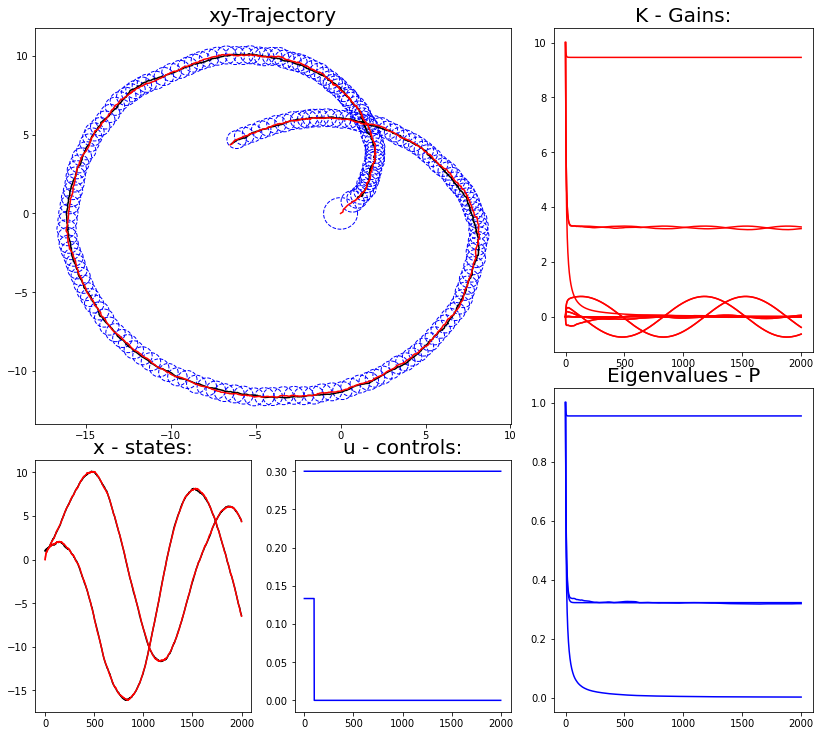

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches, matplotlib as mpl
from matplotlib.patches import Polygon

def ellipse(mu,P):
    thetas = np.linspace(0,2*np.pi,100);
    Phalf = smat.sqrtm(P);
    return mu+np.dot(Phalf,np.array([np.cos(thetas),np.sin(thetas)])).T;


fig,ax = plt.subplots(1,5,figsize=(12,10));

ax[0].set_position([0.05,0.45,0.55,0.55]); #gs[0:2].get_position(fig))
ax[1].set_position([0.05,0.05,0.25,0.35]); #gs[0:2].get_position(fig))
ax[2].set_position([0.35,0.05,0.25,0.35]); #gs[0:2].get_position(fig))
ax[3].set_position([0.65,0.55,0.3,0.45]); #gs[0:2].get_position(fig))
ax[4].set_position([0.65,0.05,0.3,0.45]); #gs[0:2].get_position(fig))


ax[0].set_title('xy-Trajectory',fontsize=20)
ax[0].plot(x[:,0],x[:,1],'k-')
ax[0].plot(xh[:,0],xh[:,1],'r-')

for t in range(T)[::10]:
    ax[0].add_patch(Polygon(list(ellipse(xh[t][:2],P[t][:2,:2])),
                      closed=True,fill=False,linestyle='--',edgecolor='blue'))    
    # Options: facecolor,linestyle,edgecolor,linewidth,alpha,fill,zorder
    
    
ax[1].plot(x[:,:2],'k-');  ax[1].set_title('x - states:',fontsize=20)
ax[1].plot(xh[:,:2],'r-'); 

ax[2].plot(u,'b-'); ax[2].set_title('u - controls:',fontsize=20);
    
ax[3].set_title('K - Gains:',fontsize=20);
for i in range(K.shape[2]):
    ax[3].plot(K[:,:,i],'r-');

ax[4].set_title('Eigenvalues - P',fontsize=20);
ax[4].plot(eigP,'b-')
#ax[4].plot(eigPp,'b-')

## Unscented Kalman Filter
    
\begin{align*}
\textbf{Model:} &  \qquad 
x_{k+1} = f(x_k,u_k,w_k,k), \qquad w(t) \sim \mathcal{N}(0,Q_k) \\
& \qquad \tilde{y}_k  = h(x_k,u_k,v_k,k), \qquad v_k \sim \mathcal{N}\big(0,R_k\big)  \\
\textbf{Sample:}
& \qquad x_k^a = \begin{bmatrix} x_k \\ w_k \\ v_k \end{bmatrix},
\quad
\hat{x}_k^a = \begin{bmatrix}
\hat{x}_k \\ 0 \\ 0
\end{bmatrix}, \qquad P_k^a = \begin{bmatrix}
P_k^+ & P_k^{xw} & P_k^{xv} \\
(P_k^{xw})^T & Q_k  & P_k^{wv} \\
(P_k^{xv})^T & (P_k^{wv})^T & R_k
\end{bmatrix} \\
& \qquad 
P = MM^T, \quad M = \sqrt{P_k^a}, \quad \textbf{using Cholesky, SVD, etc...} \\ 
& \qquad 
\sigma_k^{(i)} = \text{cols of $\pm \gamma \sqrt{P_k^a}$} \\
& \qquad \chi_k^{a(0)} = \hat{x}_k^a, \quad \chi_k^{a(i)} = \hat{x}_k^a + \sigma_k^{(i)}, \quad i =1,2,\dots,2L, \quad
\chi_k^{a(i)} =
\begin{bmatrix}
\chi_k^{x(i)} \\ 
\chi_k^{w(i)} \\
\chi_k^{v(i)}
\end{bmatrix}
\\
\textbf{Propagate:}
& \qquad \chi_{k+1}^{x(i)} = f(\chi_k^{x(i)},\chi_k^{w(i)},u_k,k) \\
& \qquad \gamma_{k}^{(i)} = h(\chi_k^{x(i)},u_k,\chi_k^{v(i)},k)) \\
\textbf{Reconstruct:}
& \qquad 
\hat{x}_k^- = \sum_{i=0}^{2L}W_i^\text{mean} \chi_k^{x(i)}, \qquad 
P_k^- = \sum_{i=0}^{2L}W_i^\text{cov}\big[\chi_k^{x(i)}-\hat{x}_k^- \big]\big[\chi_k^{x(i)}-\hat{x}_k^- \big]^T \\
& \qquad 
\hat{y}_k^- = \sum_{i=0}^{2L}W_i^\text{mean} \gamma_k^{(i)}, \qquad P_{k}^{e_ye_y} = \sum_{i=0}^{2L} W_i^\text{cov}
\big[\gamma_k^{(i)}-\hat{y}_k^- \big]\big[\gamma_k^{(i)}-\hat{y}_k^- \big]^T \\
& \qquad 
P_{k}^{e_xe_y} = \sum_{i=0}^{2L} W_i^\text{cov}
\big[\chi_k^{x(i)}-\hat{x}_k^- \big]\big[\gamma_k^{(i)}-\hat{y}_k^- \big]^T \\
\textbf{Gain:} & \qquad K_k = P_k^{e_xe_y}\big(P_k^{e_ye_y}\big)^{-1} \\
\textbf{Update:} & \qquad \hat{x}_k^+ = \hat{x}_k^- + K_ke_k^- = \hat{x}_k^- + K_k\big(\tilde{y}_k - \hat{y}_k^-\big) \\
& \qquad 
P_k^+ = P_k^- - K_k P_k^{e_ye_y}K_k^T \\
\textbf{Params/weights:} & \qquad L: \ \ \text{length of $x_k^a$}, \quad \gamma = \sqrt{L+\lambda}, \quad \lambda = \alpha^2(L+\kappa) - L \\
& \qquad 10^{-4} \leq \alpha \leq 1, \quad \beta = 2 \\
& \qquad W_0^\text{mean} = \frac{\lambda}{L+\lambda}, \qquad W_0^\text{cov} = \frac{\lambda}{L+\lambda} + \big(1-\alpha^2+\beta) \\
& \qquad W_i^\text{mean} = W_i^\text{cov} = \frac{1}{2(L+\lambda)}, \quad i=1,2,\dots,2L
\end{align*}


### simulate real dynamics...

In [31]:
for t in range(T):    
    w[t]   = vecnormal(np.zeros(q),Q);            
    if t < T-1:
        x[t+1] = phi(x[t],u[t],w[t]);     

### Unscented - run fillter

In [34]:
import numpy as np
import numpy.linalg as mat
import scipy.linalg as smat
from numpy.random import multivariate_normal as vecnormal
from numpy.random import normal as normal

# parameters
alpha = 0.1; beta = 1; kappa = 2; #0.0001 < alpha < 1
L = n + q + o;
lam = (alpha*alpha)*(L+kappa)-L;
gam = np.sqrt(L+lam);

# weights
wm0 = lam/(L+lam); wmi = 1/(2*(L+lam));
wc0 = wm0 + (1-alpha*alpha+beta); wci = wmi;

# preallocating for sample points...
# for state estimates...
X0 = np.zeros([T,n]); Xp = np.zeros([T,L,n]); Xm = np.zeros([T,L,n]);
# for measurement estimates...
G0 = np.zeros([T,o]); Gp = np.zeros([T,L,o]); Gm = np.zeros([T,L,o]);
# cross correlation matrices...
Pyy= np.zeros([T,o,o]); Pxy = np.zeros([T,n,o]);

for t in range(T):    
    v[t] = vecnormal(np.zeros(o),R);
    # true output...
    y[t] = h(x[t],v[t]);

    eigPm[t] = mat.eig(Pm[t])[0];

    # augmented covariance matrix... 
    # A,B,C,D => np.block([[A,B],[C,D]]) np.hstack, np.vstack
    Pa = smat.block_diag(Pm[t],Q,R)
    # assuming no correlation between x and w, x and v, etc...
    SIG = mat.cholesky(Pa); #better conditioned numerically
    #U,D,UT = svd(Pa); SIG = U@smat.sqrtm(D)
    #augmented state...
    xa  = np.block([xhm[t],np.zeros(q),np.zeros(o)]);
    #putting the state component of xa in X0[t]...
    X0[t] = xa[:n];
    # computing sample points around distribution...
    for i in range(L):
        Xp[t,i] = (xa+gam*SIG[:,i])[:n];
        Xm[t,i] = (xa-gam*SIG[:,i])[:n];
    # pushing the sample points through the measurement equation...
    G0[t] = h(xa[:n],xa[-o:]); # middle point...
    for i in range(L):
        xsig    = xa + gam*SIG[:,i];
        Gp[t,i] = h(xsig[:n],xsig[-o:]);        
        xsig    = xa - gam*SIG[:,i];
        Gm[t,i] = h(xsig[:n],xsig[-o:]);
    
    # Reconstruction steps...
    # reconstructing expected measurement...
    yh[t]  = wm0*G0[t] + wmi*np.sum(Gp[t],-2) + wmi*np.sum(Gm[t],-2);
    # xx = [1,2,3,4,5]; xx[-2:] = [4,5]
    # np.sum(Gp[t],-2): summing over the L index...
    
    # measurement correlation...
    Pyy[t] = wc0*np.outer((G0[t]-yh[t]),G0[t]-yh[t]);
    for i in range(L):
        Pyy[t] = Pyy[t] + wci*np.outer(Gp[t,i]-yh[t],Gp[t,i]-yh[t]);
        Pyy[t] = Pyy[t] + wci*np.outer(Gm[t,i]-yh[t],Gm[t,i]-yh[t]);
    # probably slick solution using einsum... ehhh
    
    # cross correlation component...
    Pxy[t] = wc0*np.outer(X0[t]-xhm[t],G0[t]-yh[t]);
    for i in range(L):
        Pxy[t] = Pxy[t] + wci*np.outer(Xp[t,i]-xhm[t],Gp[t,i]-yh[t]);
        Pxy[t] = Pxy[t] + wci*np.outer(Xm[t,i]-xhm[t],Gm[t,i]-yh[t]);
        
    # gain computation...    
    K[t]  = np.dot(Pxy[t],mat.inv(Pyy[t]));
    # covariance update...
    Pp[t] = Pm[t]-K[t]@Pyy[t]@K[t].T
    eigPp[t] = mat.eig(Pm[t])[0];
    
    #estimate update...
    xhp[t]= xhm[t]+np.dot(K[t],y[t]-yh[t]) 
    
    # Propagation step...
    if t < T-1:
        Pa = smat.block_diag(Pp[t],Q,R)
        SIG = mat.cholesky(Pa);
        xa  = np.block([xhp[t],np.zeros(q),np.zeros(o)]);
        
        # discrete time dynamics application...
        X0[t+1] = phi(xa[:n],u[t],xa[n:n+q]);
        for i in range(L):
            xsig = xa + gam*SIG[:,i];
            Xp[t+1,i] = phi(xsig[:n],u[t],xsig[n:n+q]);
            xsig = xa - gam*SIG[:,i];
            Xm[t+1,i] = phi(xsig[:n],u[t],xsig[n:n+q]);
        
        # reconstructing the state and covariance estimates...
        xhm[t+1]= wm0*X0[t+1] + wmi*np.sum(Xp[t+1],-2) + wmi*np.sum(Xm[t+1],-2);
        Pm[t+1] = wc0*np.outer(X0[t+1]-xhm[t+1],X0[t+1]-xhm[t+1]);        
        for i in range(L):
            Pm[t+1] = Pm[t+1] + wci*np.outer(Xp[t+1,i]-xhm[t+1],Xp[t+1,i]-xhm[t+1]);
            Pm[t+1] = Pm[t+1] + wci*np.outer(Xm[t+1,i]-xhm[t+1],Xm[t+1,i]-xhm[t+1]);
        

### Unscented - Visualize

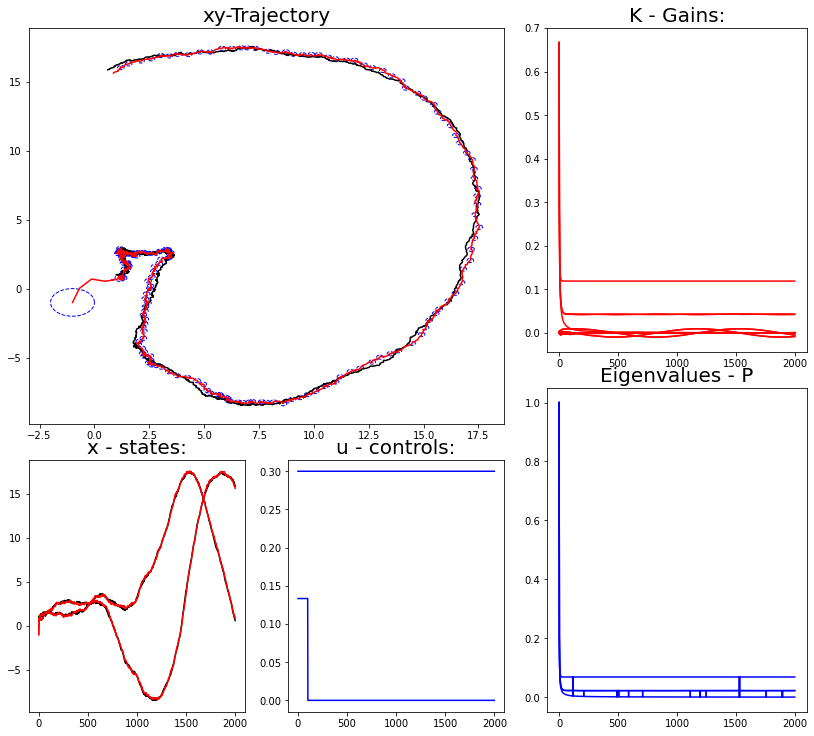

In [35]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches, matplotlib as mpl
from matplotlib.patches import Polygon

def ellipse(mu,P):
    thetas = np.linspace(0,2*np.pi,100);
    Phalf = smat.sqrtm(P);
    return mu+np.dot(Phalf,np.array([np.cos(thetas),np.sin(thetas)])).T;


fig,ax = plt.subplots(1,5,figsize=(12,10));

ax[0].set_position([0.05,0.45,0.55,0.55]); #gs[0:2].get_position(fig))
ax[1].set_position([0.05,0.05,0.25,0.35]); #gs[0:2].get_position(fig))
ax[2].set_position([0.35,0.05,0.25,0.35]); #gs[0:2].get_position(fig))
ax[3].set_position([0.65,0.55,0.3,0.45]); #gs[0:2].get_position(fig))
ax[4].set_position([0.65,0.05,0.3,0.45]); #gs[0:2].get_position(fig))


ax[0].set_title('xy-Trajectory',fontsize=20)
ax[0].plot(x[:,0],x[:,1],'k-')
ax[0].plot(xhm[:,0],xhm[:,1],'r-')

for t in range(T)[::10]:
    ax[0].add_patch(Polygon(list(ellipse(xhm[t][:2],Pm[t][:2,:2])),
                      closed=True,fill=False,linestyle='--',edgecolor='blue'))    
    # Options: facecolor,linestyle,edgecolor,linewidth,alpha,fill,zorder
    
    
ax[1].plot(x[:,:2],'k-');  ax[1].set_title('x - states:',fontsize=20)
ax[1].plot(xhm[:,:2],'r-'); 

ax[2].plot(u,'b-'); ax[2].set_title('u - controls:',fontsize=20);
    
ax[3].set_title('K - Gains:',fontsize=20);
for i in range(K.shape[2]):
    ax[3].plot(K[:,:,i],'r-');

ax[4].set_title('Eigenvalues - P',fontsize=20);
ax[4].plot(eigPm,'b-')
